In [ ]:
#모델활용예시 코드



import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Creating a simple dataset
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print("Linear Regression MSE:", mse_lin)

# Ridge Regression
ridge_reg = Ridge(alpha=1)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Ridge Regression MSE:", mse_ridge)

# Lasso Regression
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Lasso Regression MSE:", mse_lasso)





In [3]:
cd ..

/


In [24]:

# 같은 년도에 여러팀에서 뛴 경우 평균치를 구해쓰기
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/2010-2021_stat.csv')

# Group by player name and year and calculate weighted averages based on the number of games played (G)
grouped_data = data.groupby(['name', 'start']).apply(
    lambda x: pd.Series({
        'Tm': ', '.join(x['Tm'].unique()),
        'Pos': x['Pos'].iloc[0],
        'Age': (x['Age'] * x['G']).sum() / x['G'].sum(),  # Weighted average age
        'G': x['G'].sum(),
        'GS': (x['GS'] * x['G']).sum() / x['G'].sum(),     # Weighted average games started
        'MP': (x['MP'] * x['G']).sum() / x['G'].sum(),
        'FG': (x['FG'] * x['G']).sum() / x['G'].sum(),
        'FGA': (x['FGA'] * x['G']).sum() / x['G'].sum(),
        'FG%': (x['FG%'] * x['G']).sum() / x['G'].sum(),
        '3P': (x['3P'] * x['G']).sum() / x['G'].sum(),
        '3PA': (x['3PA'] * x['G']).sum() / x['G'].sum(),
        '3P%': (x['3P%'] * x['G']).sum() / x['G'].sum(),
        '2P': (x['2P'] * x['G']).sum() / x['G'].sum(),
        '2PA': (x['2PA'] * x['G']).sum() / x['G'].sum(),
        '2P%': (x['2P%'] * x['G']).sum() / x['G'].sum(),
        'eFG%': (x['eFG%'] * x['G']).sum() / x['G'].sum(),
        'FT': (x['FT'] * x['G']).sum() / x['G'].sum(),
        'FTA': (x['FTA'] * x['G']).sum() / x['G'].sum(),
        'FT%': (x['FT%'] * x['G']).sum() / x['G'].sum(),
        'ORB': (x['ORB'] * x['G']).sum() / x['G'].sum(),
        'DRB': (x['DRB'] * x['G']).sum() / x['G'].sum(),
        'TRB': (x['TRB'] * x['G']).sum() / x['G'].sum(),
        'AST': (x['AST'] * x['G']).sum() / x['G'].sum(),
        'STL': (x['STL'] * x['G']).sum() / x['G'].sum(),
        'BLK': (x['BLK'] * x['G']).sum() / x['G'].sum(),
        'TOV': (x['TOV'] * x['G']).sum() / x['G'].sum(),
        'PF': (x['PF'] * x['G']).sum() / x['G'].sum(),
        'PTS': (x['PTS'] * x['G']).sum() / x['G'].sum()
    })
).reset_index()

# Save the processed dataset to a new CSV file
output_file_all_features = '/content/processed_2010-2021_stat_all_features.csv'
grouped_data.to_csv(output_file_all_features, index=False)

output_file_all_features

'/content/processed_2010-2021_stat_all_features.csv'

In [25]:
#1년치 데이터합치는 코드
import pandas as pd

# 데이터 로드
stat_data = pd.read_csv('/content/2010-2021stat.csv', encoding='ISO-8859-1')
stat_data.head()
salary_data=pd.read_csv('/content/all_salary_data.csv', encoding='ISO-8859-1')
salary_data.head()
merged_data = pd.merge(stat_data, salary_data, on=['name', 'start'])
merged_data = merged_data.drop_duplicates()
# Display the number of missing values in each column
print(merged_data.isnull().sum())

# Drop rows with any missing values
merged_data = merged_data.dropna()

# Display the first few rows after removing duplicates and handling missing values
print(merged_data.head())
merged_data.to_csv('combined_data.csv', index=False)
# Display the first few rows of the merged dataset
print(merged_data.head())


name      0
start     0
Tm        0
Pos       0
Age       0
G         0
GS        0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
debut     0
end       0
salary    0
birth     0
target    0
dtype: int64
           name  start             Tm Pos   Age    G         GS         MP  \
0  Aaron Brooks   2013  TOT, SAC, HOU  PG  28.0  106  18.679245  18.783019   
1  Aaron Brooks   2014  TOT, HOU, DEN  PG  29.0  144   8.416667  21.627083   
2  Aaron Brooks   2015            CHI  PG  30.0   82  21.000000  23.000000   
3  Aaron Brooks   2016            CHI  PG  31.0   69   0.000000  16.100000   
4  Aaron Brooks   2017            IND  PG  32.0   65   0.000000  13.800000   

         FG        FGA  ...       STL       BLK       TOV        PF  \
0  2.691509   5.989623  ...

In [26]:

#일단 1년치로 예측하는코드 포지션별로 다르게

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
# Load the combined dataset
data = pd.read_csv('/content/combined_data.csv')

# 포지션으로 필터링
guards = data[data['Pos'].isin(['PG', 'SG'])]
print(guards.shape)
forwards = data[data['Pos'].isin(['SF', 'PF'])]
print(forwards.shape)
centers = data[data['Pos'] == 'C']
print(centers.shape)

#각 포지션별 피쳐 선택
guard_features = ['AST', 'PTS', '3P%', 'FT%', 'STL', 'TOV', 'MP', 'G']

forward_features = ['PTS', 'TRB', 'AST', '3P%', 'FG%', 'STL', 'BLK', 'MP']


center_features = ['TRB', 'BLK', 'PTS', 'FG%', 'AST', 'MP', 'G', 'FT%']


def train_and_evaluate_model(data, features):
    X = data[features]
    y = data['target']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')

    return model, X_test, y_test

# Train and evaluate models for each position
print("Guard Model")
guard_model, guard_X_test, guard_y_test = train_and_evaluate_model(guards, guard_features)

print("\nForward Model")
forward_model, forward_X_test, forward_y_test = train_and_evaluate_model(forwards, forward_features)

print("\nCenter Model")
center_model, center_X_test, center_y_test = train_and_evaluate_model(centers, center_features)

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(model, X_test, y_test, title):
    y_pred = model.predict(X_test)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
    plt.xlabel('Actual Salaries')
    plt.ylabel('Predicted Salaries')
    plt.title(f'Actual vs Predicted Salaries for {title}')
    plt.show()





(771, 35)
(659, 35)
(332, 35)
Guard Model
Mean Squared Error: 0.0027054547819682054
R^2 Score: 0.30537314159120266

Forward Model
Mean Squared Error: 0.0030224677025132824
R^2 Score: 0.5708398500896329

Center Model
Mean Squared Error: 0.003068387701727592
R^2 Score: 0.3067521461682976


Guard Model Results


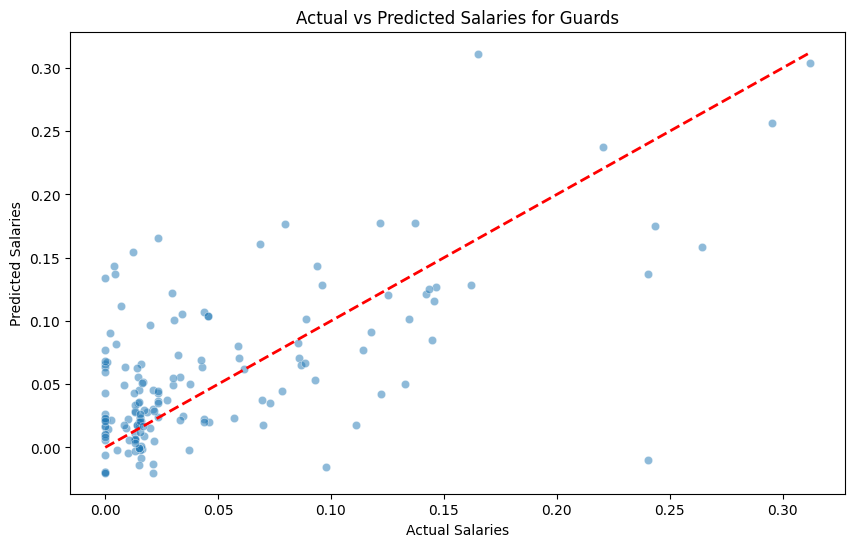

Forward Model Results


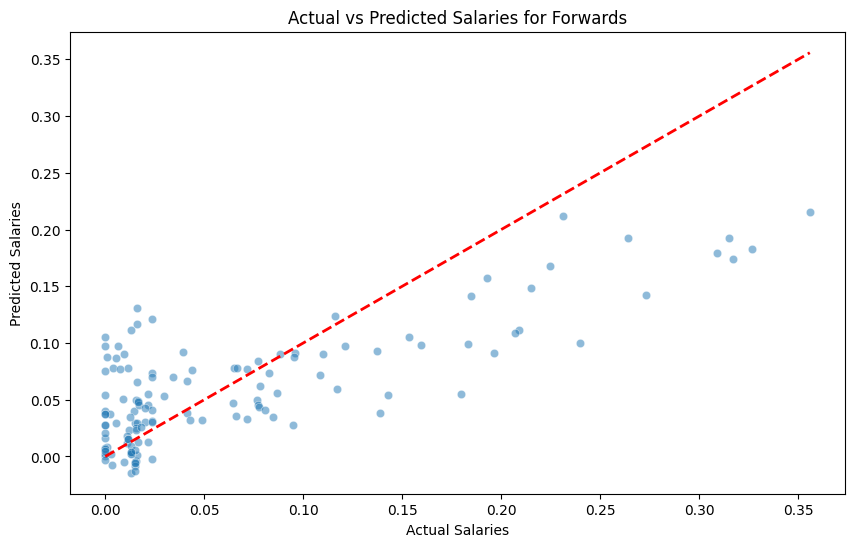

Center Model Results


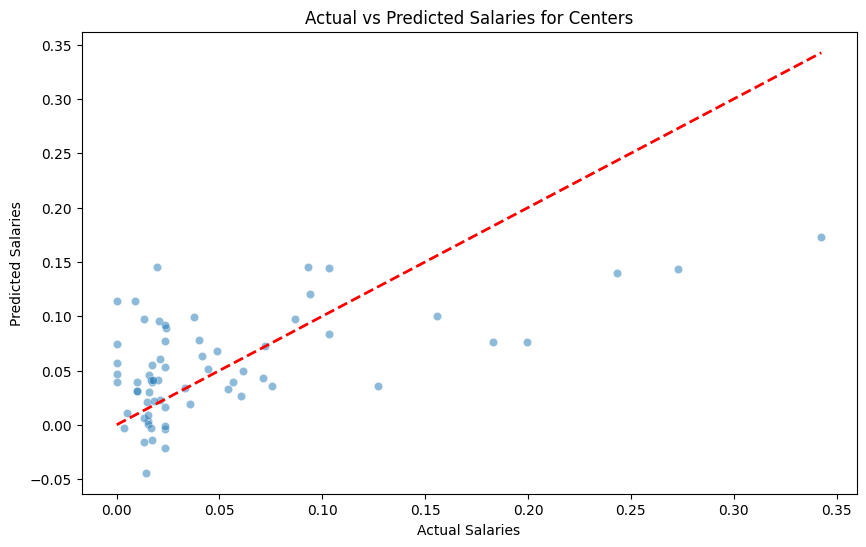

In [27]:
# Visualize results for each model
print("Guard Model Results")
visualize_results(guard_model, guard_X_test, guard_y_test, "Guards")

print("Forward Model Results")
visualize_results(forward_model, forward_X_test, forward_y_test, "Forwards")

print("Center Model Results")
visualize_results(center_model, center_X_test, center_y_test, "Centers")

           name  start             Tm Pos   Age    G         GS         MP  \
0  Aaron Brooks   2013  TOT, SAC, HOU  PG  28.0  106  18.679245  18.783019   
1  Aaron Brooks   2014  TOT, HOU, DEN  PG  29.0  144   8.416667  21.627083   
2  Aaron Brooks   2015            CHI  PG  30.0   82  21.000000  23.000000   
3  Aaron Brooks   2016            CHI  PG  31.0   69   0.000000  16.100000   
4  Aaron Brooks   2017            IND  PG  32.0   65   0.000000  13.800000   

         FG        FGA  ...       STL       BLK       TOV        PF  \
0  2.691509   5.989623  ...  0.566981  0.213208  1.297170  1.770755   
1  3.202778   8.086806  ...  0.710417  0.170139  1.621528  2.020833   
2  4.200000  10.000000  ...  0.700000  0.200000  1.900000  2.300000   
3  2.700000   6.800000  ...  0.400000  0.100000  1.200000  1.900000   
4  1.900000   4.600000  ...  0.400000  0.100000  1.000000  1.400000   

         PTS  debut   end     salary  birth    target  
0   7.114151   2007  2013   947907.0   1985  0.0

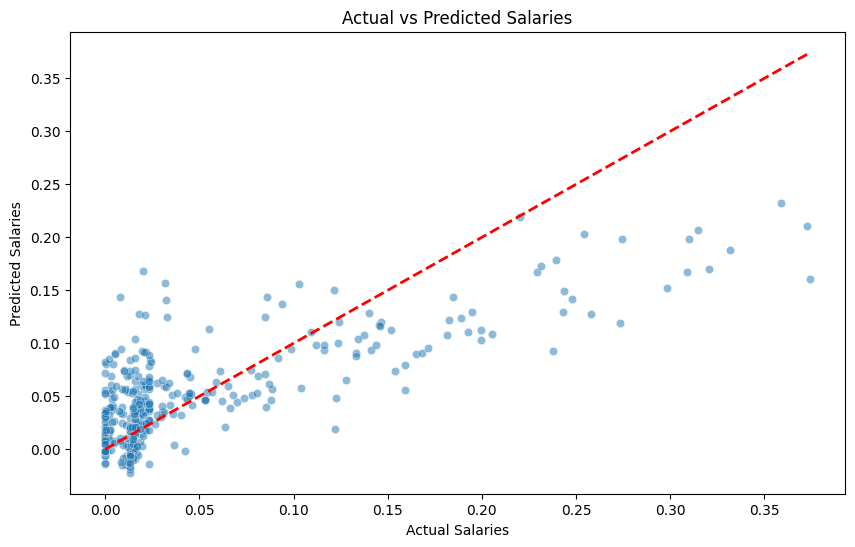

In [37]:
#모든 포지션에 대해 적용하기

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/combined_data.csv')

# Display the first few rows of the dataset to check the data
print(data.head())

# Select key features
selected_features = ['PTS','MP','FG%','AST' ,'TRB','3P%','BLK','FG']

# Define X and y
X = data[selected_features]
y = data['target']



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Actual vs Predicted Salaries')
plt.show()

           name  start             Tm Pos   Age    G         GS         MP  \
0  Aaron Brooks   2013  TOT, SAC, HOU  PG  28.0  106  18.679245  18.783019   
1  Aaron Brooks   2014  TOT, HOU, DEN  PG  29.0  144   8.416667  21.627083   
2  Aaron Brooks   2015            CHI  PG  30.0   82  21.000000  23.000000   
3  Aaron Brooks   2016            CHI  PG  31.0   69   0.000000  16.100000   
4  Aaron Brooks   2017            IND  PG  32.0   65   0.000000  13.800000   

         FG        FGA  ...       STL       BLK       TOV        PF  \
0  2.691509   5.989623  ...  0.566981  0.213208  1.297170  1.770755   
1  3.202778   8.086806  ...  0.710417  0.170139  1.621528  2.020833   
2  4.200000  10.000000  ...  0.700000  0.200000  1.900000  2.300000   
3  2.700000   6.800000  ...  0.400000  0.100000  1.200000  1.900000   
4  1.900000   4.600000  ...  0.400000  0.100000  1.000000  1.400000   

         PTS  debut   end     salary  birth    target  
0   7.114151   2007  2013   947907.0   1985  0.0

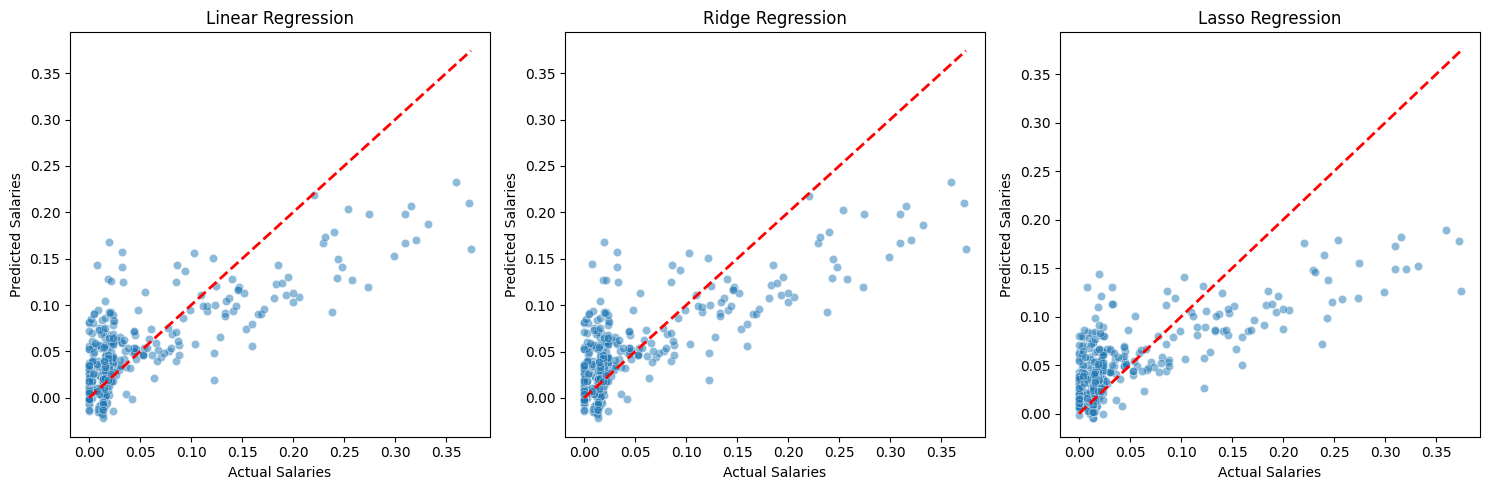

In [42]:

#ridge regression , lasso regression 모두 해보기
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/combined_data.csv')

# Display the first few rows of the dataset to check the data
print(data.head())

# Select key features
selected_features = ['PTS', 'MP', 'FG%', 'AST', 'TRB', '3P%', 'BLK', 'FG']

# Define X and y
X = data[selected_features]
y = data['target']

# Handle missing values
X = X.dropna()
y = y.loc[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions with Linear Regression
y_pred_linear = linear_model.predict(X_test_scaled)

# Initialize and train the Ridge regression model
ridge_model = Ridge(alpha=0.5)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions with Ridge Regression
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Initialize and train the Lasso regression model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)

# Make predictions with Lasso Regression
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Linear Regression - Mean Squared Error: {mse_linear}, R^2 Score: {r2_linear}')
print(f'Ridge Regression - Mean Squared Error: {mse_ridge}, R^2 Score: {r2_ridge}')
print(f'Lasso Regression - Mean Squared Error: {mse_lasso}, R^2 Score: {r2_lasso}')

# Visualize the results
plt.figure(figsize=(15, 5))

# Linear Regression Plot
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Linear Regression')

# Ridge Regression Plot
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Ridge Regression')

# Lasso Regression Plot
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Salaries')
plt.ylabel('Predicted Salaries')
plt.title('Lasso Regression')

plt.tight_layout()
plt.show()